# Glucose mQTL

Candidate list for glucose mQTL

These two genes were identified by their location relative to the QTL peaks AND (importantly) a high STITCH score. Glucose mQTL has two peaks on chrVII @ FDR ~15%. MIG1 is located under the minor peak and CTT1 under the major peak

<img src="src/gluc_mqtl.png" width="1000px"></img>

Both MIG1 and CTT1 have at least 1 SNP with "moderate" impact

In [2]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(qtl);
library(pheatmap);
library(funqtl);
library(parallel);
options(mc.cores = 24);
library(snow);
library(igraph);
library(stringr);
library(RColorBrewer);
library(jpeg);
library(pheatmap);
library(GenomicRanges);
library(zoo);


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
: package ‘qtl’ was built under R version 3.2.3Loading required package: fields
Loading required package: spam
Loading required package: grid
Spam version 1.3-0 (2015-10-24) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps

 # maps v3.1: updated 'world': all lakes moved to separate new #
 # 'lakes' database. Type '?world' or '

In [3]:
# load data
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)

# use only relative data
endometabolite = filter(endometabolite, time_format == "relative")

#head(endometabolite)

# load expression data
load("/g/steinmetz/brooks/genphen/transcriptome/data/trx_df.rda")

# load normalized QTLs
load("/g/steinmetz/brooks/genphen//metabolome/qtls/mQTLs_comball_funqtl_2014.rda")
mQTLs_funqtl_2014_class = sapply(mQTLs_funqtl_2014,class)
mQTLs_funqtl_2014 = mQTLs_funqtl_2014[mQTLs_funqtl_2014_class!="try-error"]

# load eQTLs
load("/g/steinmetz/brooks/genphen/transcriptome/qtl/eQTL_08032016.rda")

# load genotype and markers files
genotype_f = "/g/steinmetz/brooks/yeast/genomes/S288CxYJM789/genotypes_S288c_R64.rda"
load(genotype_f)

# load mQTL-eQTL correlations
load("/g/steinmetz/brooks/genphen//metabolome/qtls/mQTL_eQTL_cor.RData")

# MIG1

From SGD:

Transcription factor involved in glucose repression; sequence specific DNA binding protein containing two Cys2His2 zinc finger motifs; regulated by the SNF1 kinase and the GLC7 phosphatase; regulates filamentous growth along with Mig2p in response to glucose depletion; activated in stochastic pulses of nuclear localization, shuttling between cytosol and nucleus depending on external glucose levels and its phosphorylation state

Papers linking MIG1 to glucose metabolism

<a href="http://www.ncbi.nlm.nih.gov/pubmed/8757741">Glucose-triggered signalling in Saccharomyces cerevisiae: different requirements for sugar phosphorylation between cells grown on glucose and those grown on non-fermentable carbon sources.
</a>

<img src="http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2515871/bin/molbiolevolmsn138f02_ht.jpg">

<img src="http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2515871/bin/molbiolevolmsn138f03_lw.jpg" width="500px">

Mig1 mRNA expression levels are different between BY and YJM789 (qRT-PCR)



## Metabolite levels conditioning on MIG1 SNP @ chrVII:431867..431867

MIG1 SNP @ chrVII:431867..431867 causes missense mutation in MIG1 (YGL035C): F399S

Mutation is **NOT** in the zinc finger DNA binding domain (38-60 and 66-90)

SGD variant viewer: http://www.yeastgenome.org/variant-viewer#/S000003003?_k=hz5mh5

In [4]:
# find marker
gr <- GRanges(seqnames = Rle(c("chr07")), ranges = IRanges(431867,431867))
thismrk = names(mrk[which(mrk == gr),])

# add geno column to endometabolite data
genotype = geno[thismrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

endometabolite2plot = merge(endometabolite,genotype,by = "strain")

# remove strains w/o genotype at this marker
if (length(which(is.na(endometabolite2plot$geno)))>0) {
    data2plot = endometabolite2plot[-which(is.na(endometabolite2plot$geno)),]
} else {
    data2plot = endometabolite2plot
}
# remove NA values
if (length(which(is.na(data2plot$value.log2)))>0) {
    data2plot = data2plot[-which(is.na(data2plot$value.log2)),]
}
data2plot$geno = as.factor(data2plot$geno)

# calculate mean levels per metabolite
mo = data2plot %>% group_by(metabolite) %>% summarise(m_mean = mean(value.log2, na.rm = T))
mo = mo[order(mo$m_mean, decreasing = F),]

data2plot$metabolite = factor(data2plot$metabolite, levels = mo$metabolite)

# average replicates
data2plot = data2plot %>% group_by(metabolite, time, strain) %>% do({
        data.frame(value = mean(.$value.log2, na.rm =T), geno = .$geno[1])
 })

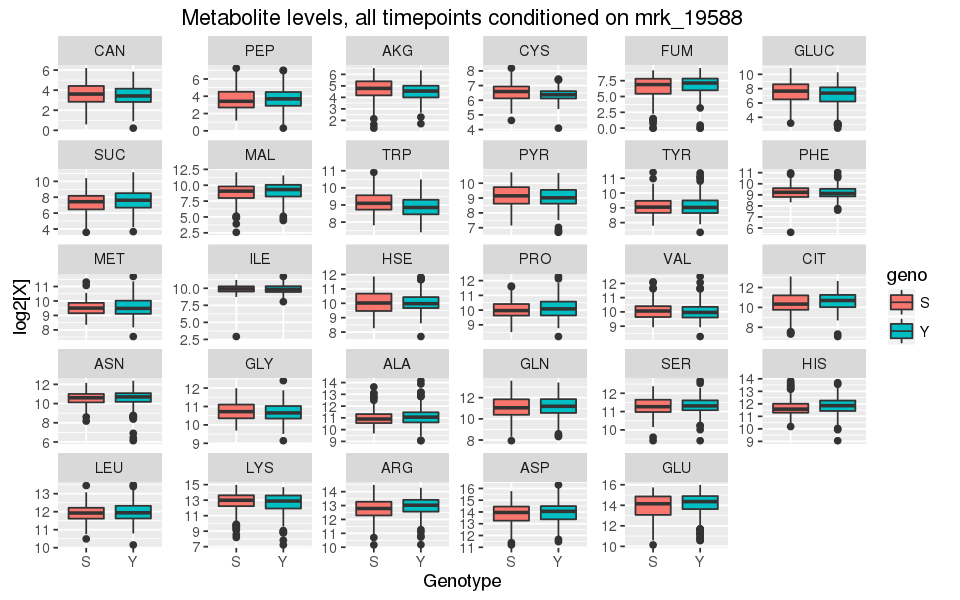

In [5]:
# plot
options(repr.plot.height = 5)
options(repr.plot.width = 8)
p <- ggplot(data2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ metabolite, scales = "free_y") + 
    labs(title = paste("Metabolite levels, all timepoints conditioned on", thismrk), 
         y = "log2[X]", x = "Genotype") 
p

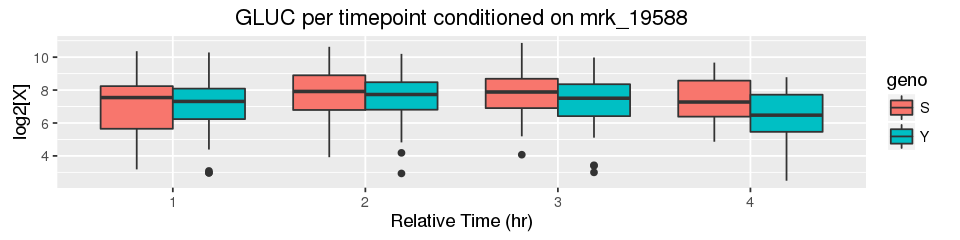

In [6]:
options(repr.plot.width = 8)
options(repr.plot.height = 2)
p <- ggplot(data2plot %>% filter(metabolite %in% "GLUC"), aes(factor(time), value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    labs(title = paste("GLUC per timepoint conditioned on", thismrk), 
         y = "log2[X]", x = "Relative Time (hr)") 
p

In [7]:
Mmrk_dif_sig = data2plot %>% filter(metabolite %in% "GLUC") %>% group_by(metabolite, time) %>% do({
    data = .
    sparent = data[data$geno=="S","value"]
    yparent = data[data$geno=="Y","value"]
    test = t.test(sparent$value, yparent$value)
    pval = test$p.value
    return(data.frame(pval))
})
Mmrk_dif_sig$pval = p.adjust(Mmrk_dif_sig$pval,method="BH")
Mmrk_dif_sig$mlog10.pval = -log10(Mmrk_dif_sig$pval)
#Mmrk_dif_sig = acast(Mmrk_dif_sig, metabolite ~ time, value.var = "pval")

Mmrk_dif_sig

,metabolite,time,pval,mlog10.pval
1,GLUC,1,0.8385565,0.07646765
2,GLUC,2,0.7188263,0.143376
3,GLUC,3,0.1607743,0.7937834
4,GLUC,4,0.0199026,1.70109


### IMPORTANT: Significant difference in GLUC levels across strains conditioned on chrVII:431867..431867 only at final time point!!

## Expression levels conditioning on MIG1 SNP @ chrVII:431867..431867

In [8]:
# load MIG1 targets
mig1_targets = read.delim("/g/steinmetz/brooks/genphen/validation/GLUC/MIG1/MIG1_targets.txt", skip = 8, sep = "\t")

genotype = geno[thismrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

trx2plot = merge(trx_df,genotype,by = "strain")
trx2plot = trx2plot[!is.na(trx2plot$geno),]

### MIG1 itself

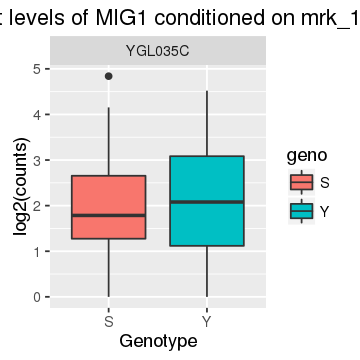

In [9]:
options(repr.plot.width = 3)
options(repr.plot.height = 3)
# average replicates
thistrx2plot = trx2plot  %>% filter(name %in% "YGL035C") %>% group_by(name, strain) %>% 
    do({
        data.frame(value = mean(log2(.$value+1), na.rm =T), geno = .$geno[1])
     })
p <- ggplot(thistrx2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ name, ncol = 4, scales = "free_y") + 
    labs(title = paste("Transcript levels of MIG1 conditioned on", thismrk), 
         y = "log2(counts)", x = "Genotype")
p

### Genes regulated by MIG1

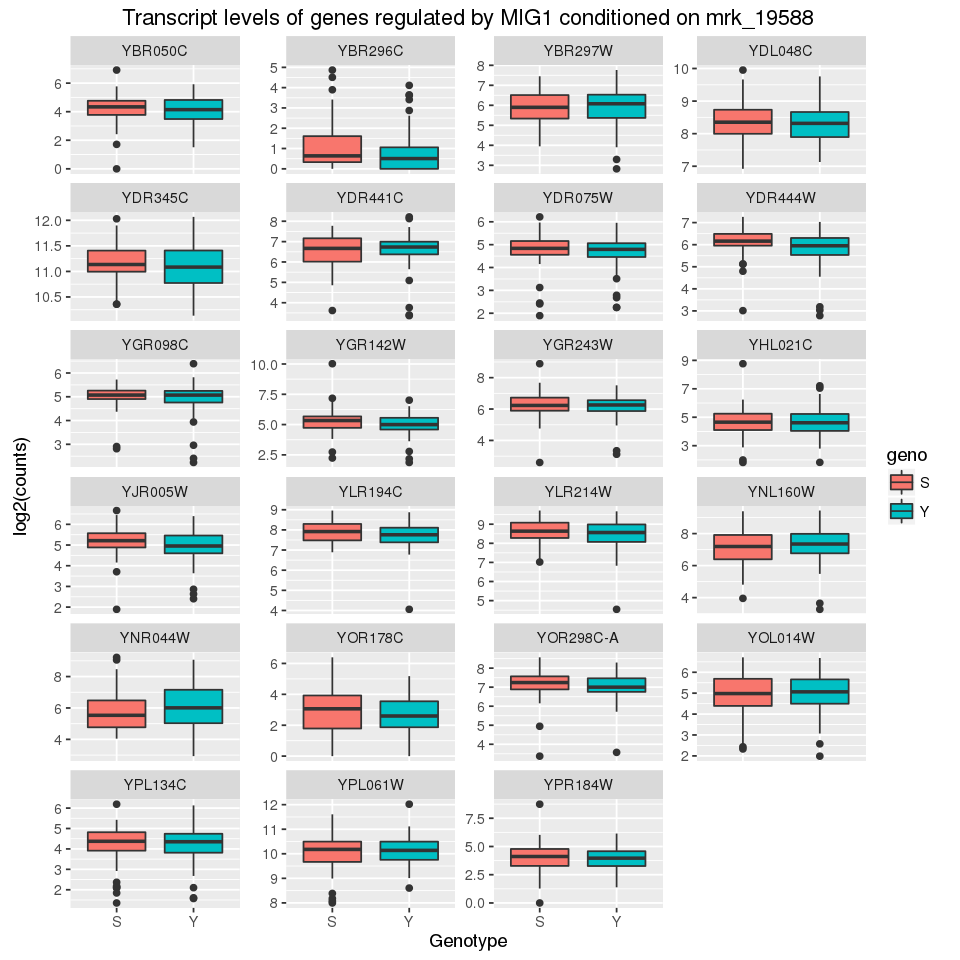

In [10]:
options(repr.plot.width = 8)
options(repr.plot.height = 8)
# average replicates
thistrx2plot = trx2plot  %>% filter(name %in% mig1_targets$Target.Systematic.Name) %>% group_by(name, strain) %>% 
    do({
        data.frame(value = mean(log2(.$value+1), na.rm =T), geno = .$geno[1])
     })
p <- ggplot(thistrx2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ name, ncol = 4, scales = "free_y") + 
    labs(title = paste("Transcript levels of genes regulated by MIG1 conditioned on", thismrk), 
         y = "log2(counts)", x = "Genotype")
p

Few differences. Could be because:
- Genes are not regulated by MIG1
- Sample was not collected at right time

# CTT1

Cytosolic catalase T; has a role in protection from oxidative damage by hydrogen peroxide

Papers linking gene to glucose metabolism.

<a href="http://www.ncbi.nlm.nih.gov/pubmed/8757741">Glucose-triggered signalling in Saccharomyces cerevisiae: different requirements for sugar phosphorylation between cells grown on glucose and those grown on non-fermentable carbon sources.
</a>

## Metabolite levels conditioning on CTT1 (YGR088W) SNP @ chrVII:655396..655396

CTT1 has two missense mutations at A255T and C539G

The first A255T is in the catalase domain, so we'll focus on that one

SGD variant viewer: http://www.yeastgenome.org/variant-viewer#/S000003320?_k=rikntg

In [10]:
# find marker
gr <- GRanges(seqnames = Rle(c("chr07")), ranges = IRanges(655396,655396))
thismrk = names(mrk[which(mrk == gr),])

# add geno column to endometabolite data
genotype = geno[thismrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

endometabolite2plot = merge(endometabolite,genotype,by = "strain")

# remove strains w/o genotype at this marker
if (length(which(is.na(endometabolite2plot$geno)))>0) {
    data2plot = endometabolite2plot[-which(is.na(endometabolite2plot$geno)),]
} else {
    data2plot = endometabolite2plot
}
# remove NA values
if (length(which(is.na(data2plot$value.log2)))>0) {
    data2plot = data2plot[-which(is.na(data2plot$value.log2)),]
}
data2plot$geno = as.factor(data2plot$geno)

# calculate mean levels per metabolite
mo = data2plot %>% group_by(metabolite) %>% summarise(m_mean = mean(value.log2, na.rm = T))
mo = mo[order(mo$m_mean, decreasing = F),]

data2plot$metabolite = factor(data2plot$metabolite, levels = mo$metabolite)

# average replicates
data2plot = data2plot %>% group_by(metabolite, time, strain) %>% do({
        data.frame(value = mean(.$value.log2, na.rm =T), geno = .$geno[1])
 })

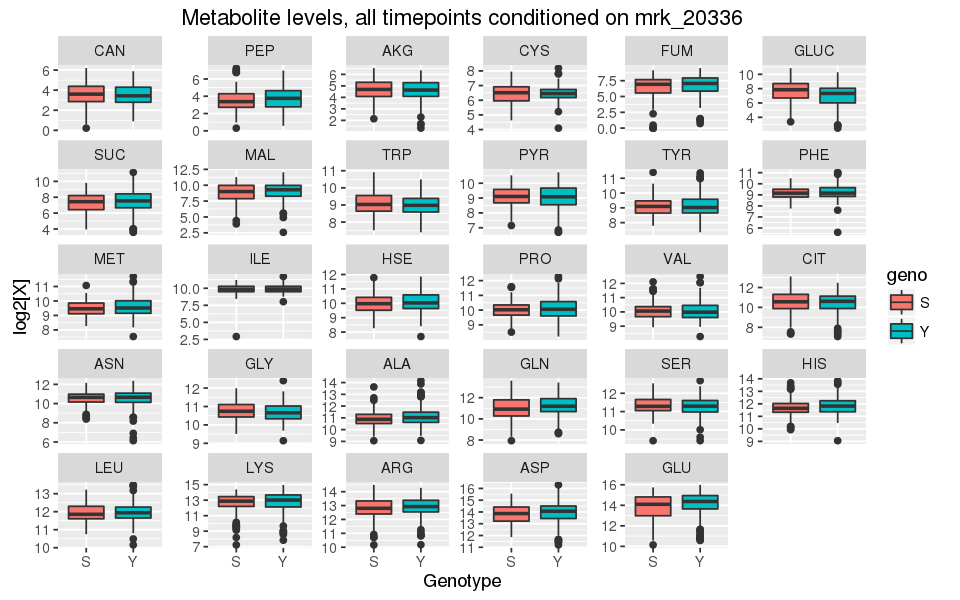

In [11]:
# plot
options(repr.plot.height = 5)
options(repr.plot.width = 8)
p <- ggplot(data2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ metabolite, scales = "free_y") + 
    labs(title = paste("Metabolite levels, all timepoints conditioned on", thismrk), 
         y = "log2[X]", x = "Genotype") 
p

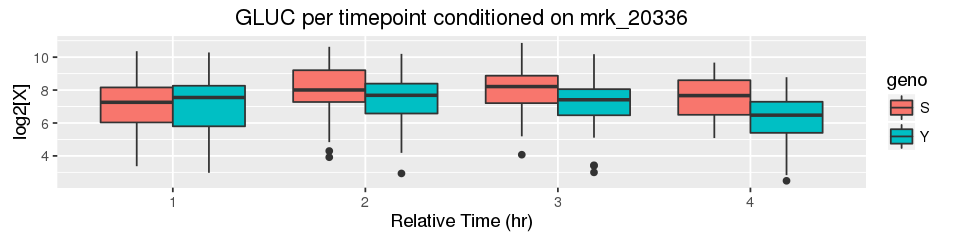

In [12]:
options(repr.plot.width = 8)
options(repr.plot.height = 2)
p <- ggplot(data2plot %>% filter(metabolite %in% "GLUC"), aes(factor(time), value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    labs(title = paste("GLUC per timepoint conditioned on", thismrk), 
         y = "log2[X]", x = "Relative Time (hr)") 
p

In [13]:
Mmrk_dif_sig = data2plot %>% filter(metabolite %in% "GLUC") %>% group_by(metabolite, time) %>% do({
    data = .
    sparent = data[data$geno=="S","value"]
    yparent = data[data$geno=="Y","value"]
    test = t.test(sparent$value, yparent$value)
    pval = test$p.value
    return(data.frame(pval))
})
Mmrk_dif_sig$pval = p.adjust(Mmrk_dif_sig$pval,method="BH")
Mmrk_dif_sig$mlog10.pval = -log10(Mmrk_dif_sig$pval)
#Mmrk_dif_sig = acast(Mmrk_dif_sig, metabolite ~ time, value.var = "pval")

Mmrk_dif_sig

,metabolite,time,pval,mlog10.pval
1,GLUC,1,0.8502199,0.07046874
2,GLUC,2,0.1800346,0.7446441
3,GLUC,3,0.02468852,1.607505
4,GLUC,4,0.00024754,3.606355


## Expression levels conditioning on CTT1 SNP @ chrVII:431867..431867

In [14]:
genotype = geno[thismrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

trx2plot = merge(trx_df,genotype,by = "strain")
trx2plot = trx2plot[!is.na(trx2plot$geno),]

### CTT1 itself

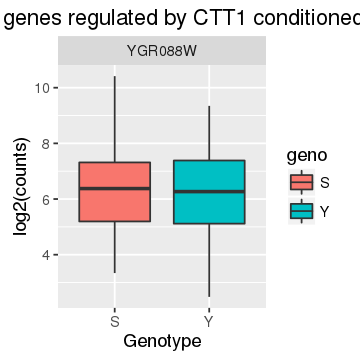

In [15]:
options(repr.plot.width = 3)
options(repr.plot.height = 3)
# average replicates
thistrx2plot = trx2plot  %>% filter(name %in% "YGR088W") %>% group_by(name, strain) %>% 
    do({
        data.frame(value = mean(log2(.$value+1), na.rm =T), geno = .$geno[1])
     })
p <- ggplot(thistrx2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ name, ncol = 4, scales = "free_y") + 
    labs(title = paste("Transcript levels of genes regulated by CTT1 conditioned on", thismrk), 
         y = "log2(counts)", x = "Genotype")
p

# Both MIG1 and CTT1

### Highly correlated mQTL-eQTL profiles, cor > 0.5

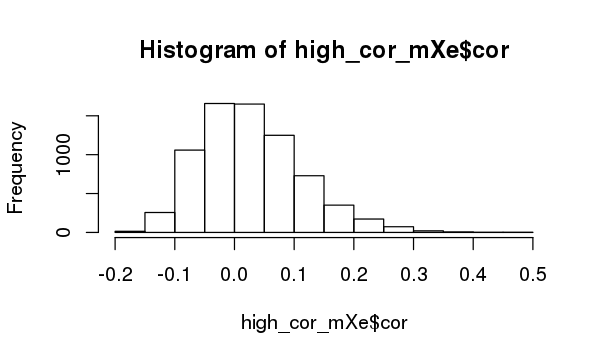

In [16]:
high_cor_mXe = mQTL_eQTL_cor %>% filter(metabolite == "GLUC")
options(repr.plot.width = 5)
options(repr.plot.height = 3)
hist(high_cor_mXe$cor)
gnames = high_cor_mXe[order(high_cor_mXe$cor, decreasing = T),]
gnames = gnames %>% filter(cor >= quantile(high_cor_mXe$cor,probs=.995,na.rm=T))
gnames = gnames$gene

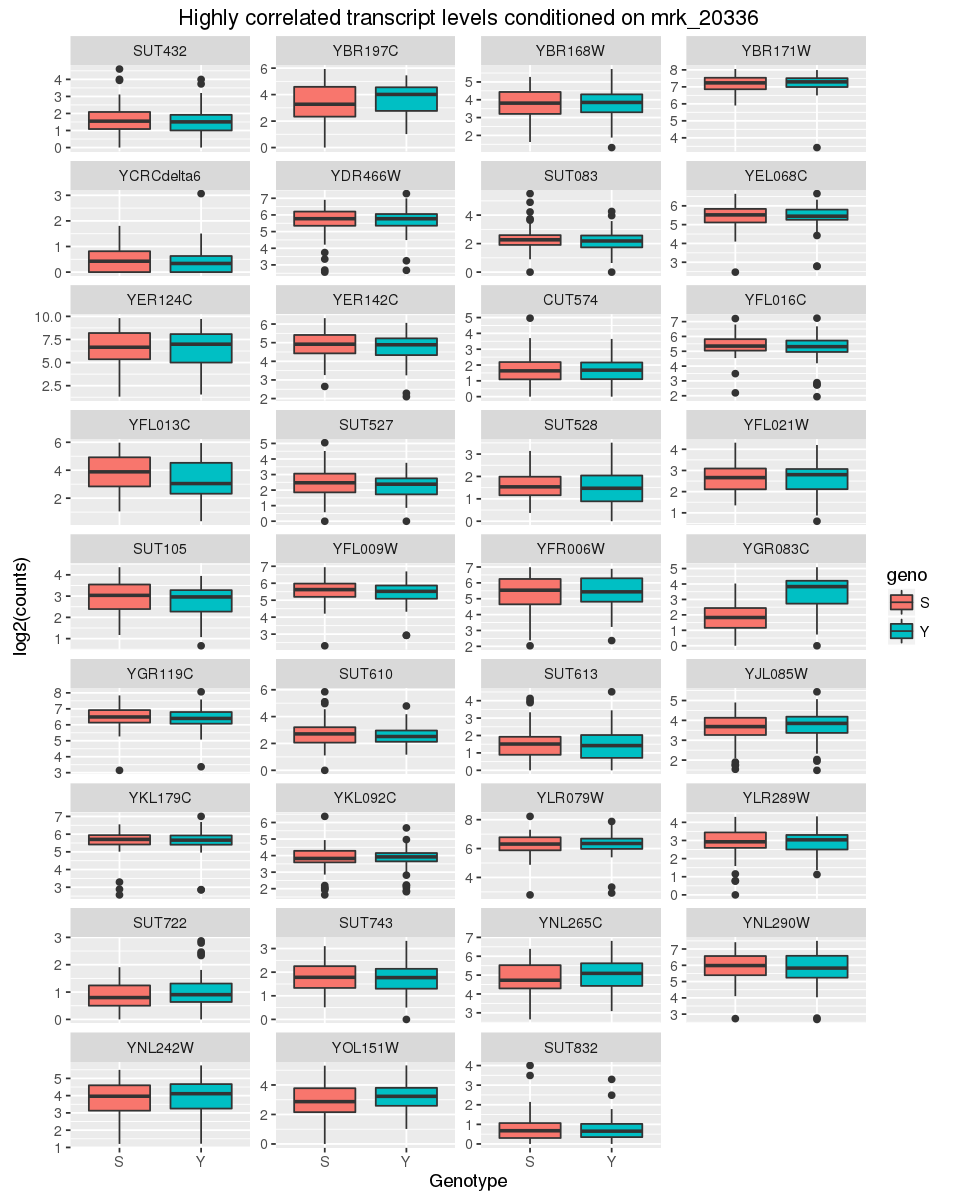

In [17]:
options(repr.plot.width = 8)
options(repr.plot.height = 10)
# average replicates
thistrx2plot = trx2plot  %>% filter(name %in% gnames) %>% group_by(name, strain) %>% do({
        data.frame(value = mean(log2(.$value+1), na.rm =T), geno = .$geno[1])
     })
p <- ggplot(thistrx2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ name, ncol = 4, scales = "free_y") + 
    labs(title = paste("Highly correlated transcript levels conditioned on", thismrk), 
         y = "log2(counts)", x = "Genotype")
p

# Conclusions

CTT1 is higher confidence GLUC mQTL. Effect can be seen significantly at multiple timepoints. Effect not observed in RNA levels. This could be due to growth state in which samples were taken. RNA was collected at a single time point.

MIG1 is a possible GLUC mQTL. If so, effect is weak. Only see significant effect at later growth timepoints. RNA data does not indicate effect on expression or on genes regulated by MIG1